<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# TROLL HUNTING: DETECTING STATE-BACKED DISINFORMATION CAMPAIGNS ON TWITTER

# NOTEOOK 3.2: ALTERNATIVE IRAN MODEL AND EVALUATION
The first model we built with a mixture of Russian and American tweets did well in picking out unseen Russian fake tweets. But it failed to do as well with unseen Iranian and Venezuelian fake tweets which contained words that the model was not familiar with, or saw very little of in its training set.

So this raises an obvious question: Would a similar model trained with Iranian fake tweets do as well in detecting unseen Iranian tweets? Let's find out by repeating the steps in creating our first model, but using 25,000 Iranian state-backed tweets this time.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, mean_squared_error, precision_score, recall_score
from sklearn.pipeline import Pipeline, make_pipeline

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

## 1. PRE-PROCESSING

In [2]:
# Calling up a new Iranian set created for this test
iran_en = pd.read_csv('../data/iran_full_en.csv')

In [3]:
# Splitting this new Iran dataset into 2 - 1 for training, 1 as an unseen test set
iran_train = iran_en.sample(n=25000, random_state=42)
iran_unseen = iran_en.sample(n=1000, random_state=7)

In [4]:
# Repeating the same cleaning steps
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub("\W", " ", text)
    text = re.sub("\s+", " ", text)
    text = text.strip(" ")
    text = text.strip("\n")
    text = re.sub("[^\w\s]", "", text)
    return text

In [5]:
iran_train['clean_tweet_text'] = iran_train['tweet_text'].map(lambda tweet: clean_tweet(tweet))
iran_unseen['clean_tweet_text'] = iran_unseen['tweet_text'].map(lambda tweet: clean_tweet(tweet))

In [6]:
iran_train['clean_tweet_text'] = iran_train['clean_tweet_text'].dropna().copy()
iran_unseen['clean_tweet_text'] = iran_unseen['clean_tweet_text'].dropna().copy()

In [7]:
# Calling up the same set of real tweets used to train the first model 
real = pd.read_csv('../data/real.csv')
real_train = real.sample(n=25000, random_state=7).copy()

In [8]:
#Creating a new col to classify the real Vs state-backed tweets
iran_train['bot_or_not'] = 1
iran_unseen['bot_or_not'] = 1
real_train['bot_or_not'] = 0

In [9]:
iran5050 = pd.concat((iran_train, real_train), axis=0, sort=True)

In [10]:
iran5050['clean_tweet_text'] = iran5050['clean_tweet_text'].fillna("missing text")

In [11]:
y = iran5050['bot_or_not']
X = iran5050['clean_tweet_text']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
y_test.value_counts()

0    6256
1    6244
Name: bot_or_not, dtype: int64

## 2. SETTING A BASELINE PERFORMANCE VIA DUMMY CLASSIFIER

In [14]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [15]:
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

In [16]:
dummy_pred = dummy.predict(X_test)

In [17]:
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))
print("Precision Score : ", precision_score(y_test, dummy_pred))
print("Recall Score:", recall_score(y_test, dummy_pred))
print("f1 Score:", f1_score(y_test, dummy_pred))

Accuracy Score: 0.50864
Precision Score :  0.5080645161290323
Recall Score: 0.5145739910313901
f1 Score: 0.5112985359643539


## 3. NEW LOGREG PIPELINE
Since we've established the LogReg model as the best one in notebook 3.0, I shall stick with that here.

In [18]:
models = {
    "LogReg_Iran": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", LogisticRegression()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": [1],
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": [None],
            "vect__ngram_range": [(1, 2)],  
            "tfidf__use_idf": [True, False],
            "tfidf__norm": ["l2"],
            "clf__penalty": ["l2"],
            "clf__C": np.logspace(-4, 4, 40),
            "clf__solver": ["liblinear"],
        },
    )
}

In [19]:
for name, (model, parameters) in models.items():
    print("----- {} -----".format(name))
    gs = GridSearchCV(model, parameters, cv=5, verbose=0, n_jobs=-1, scoring="roc_auc")
    gs.fit(X_train, y_train)
    print("Best Parameters:", gs.best_params_)
    print("")
    print("Best Score:", gs.best_score_)

    joblib.dump(gs.best_estimator_, f"{name}.pkl", compress=1)
    joblib.dump(gs.cv_results_, f"{name}_results.pkl", compress=1)

    y_pred = gs.predict(X_test)

    print("")
    print("Precision Score :", precision_score(y_test, y_pred))
    print("Recall Score:", recall_score(y_test, y_pred))
    print("f1 Score:", f1_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred))
    print("")

----- LogReg_Iran -----
Best Parameters: {'clf__C': 10000.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}

Best Score: 0.9642000960721918

Precision Score : 0.926792578973759
Recall Score: 0.8880525304292121
f1 Score: 0.9070090782694037



### Interestingly, the LogReg model for the Iranian training set performed better than the LogReg model for the Russian set.

## 4. TESTING THE IRAN LOGREG MODEL AGAINST AN UNSEEN TEST SET

In [20]:
LR_iran = joblib.load("LogReg_Iran.pkl")

In [21]:
# Showing the finalised LR model the full training data-set, ahead of testing it on unseen data
LR_iran.fit(X,y)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

### 4.1 A 50-50 TEST
Let's start with an easy test, with an even mix of fake and real tweets among the 100 tweets that we will test the model on. 

In [22]:
# Recalling the third test-set of real tweets created earlier for this purpose 
real_test4 = pd.read_csv('../data/real_test4.csv')

In [23]:
real_test4['clean_tweet_text'] = real_test4['tweet_text'].map(lambda tweet: clean_tweet(tweet))

In [24]:
#Creating a new col to classify the real Vs state-backed tweets
iran_unseen['bot_or_not'] = 1
real_test4['bot_or_not'] = 0

In [25]:
iran_new_sample = pd.concat((iran_unseen, real_test4), axis=0, sort=True)

In [26]:
# Grab a sample of 100 tweets from the unseen set
iranian_test = iran_new_sample.sample(n=100, random_state=42)

In [27]:
y_iranian = iranian_test['bot_or_not']
X_iranian = iranian_test['clean_tweet_text']

In [28]:
y_iranian.value_counts()

0    53
1    47
Name: bot_or_not, dtype: int64

In [29]:
pred_iranian5050 = LR_iran.predict(X_iranian)
pred_iranian5050

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [30]:
pred_proba_iranian5050 = LR_iran.predict_proba(X_iranian)

In [31]:
cm_iranian5050 = confusion_matrix(y_iranian, pred_iranian5050)
cm_iranian5050

array([[51,  2],
       [ 3, 44]])

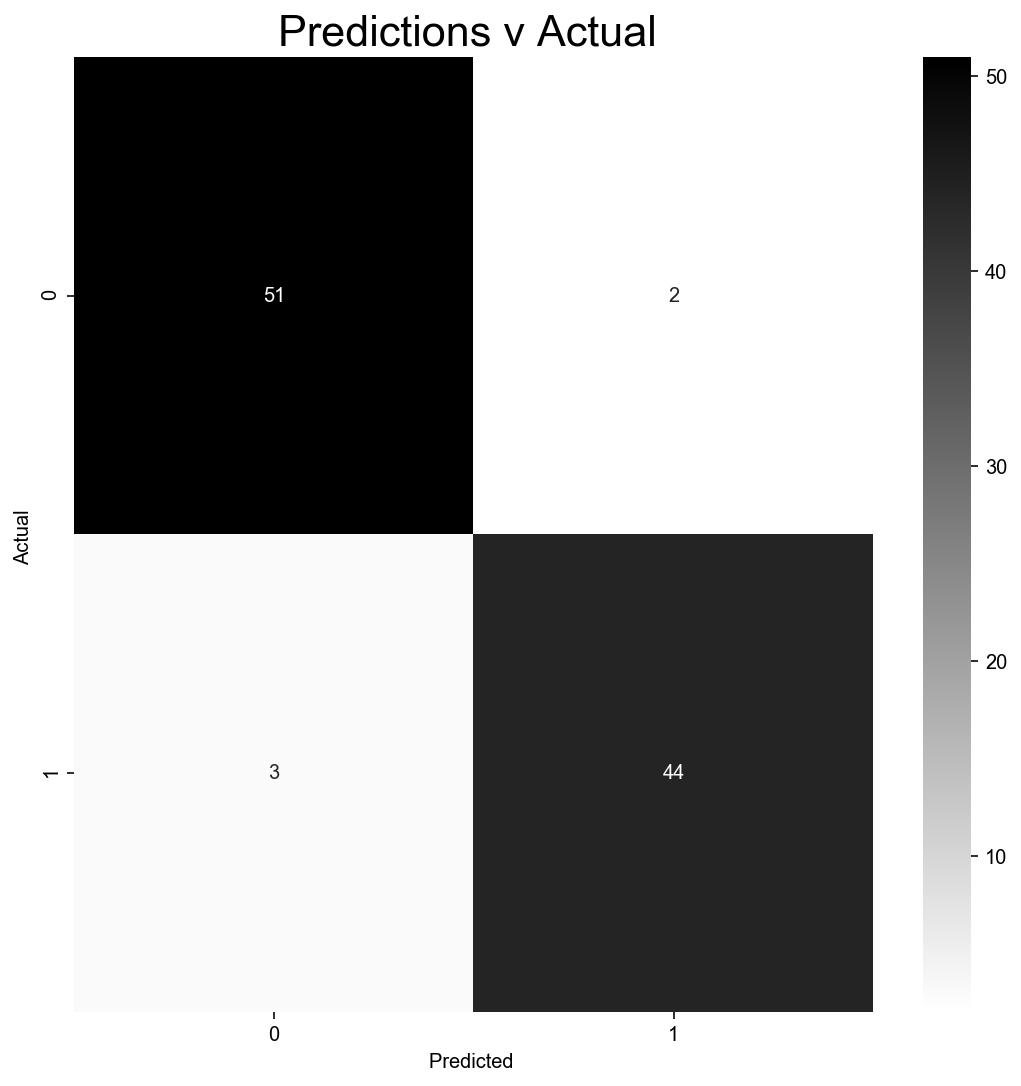

In [32]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_iranian5050, annot=True, fmt="d", cmap="gist_gray_r")
sns.set(font_scale=1.8)
plt.title("Predictions v Actual ")
plt.ylabel("Actual ")
plt.xlabel("Predicted ")
plt.tight_layout()

In [33]:
print("Accuracy Score:", accuracy_score(y_iranian, pred_iranian5050))
print("Precision Score :", precision_score(y_iranian, pred_iranian5050))
print("Recall Score:", recall_score(y_iranian, pred_iranian5050))
print("f1 Score:", f1_score(y_iranian, pred_iranian5050))

Accuracy Score: 0.95
Precision Score : 0.9565217391304348
Recall Score: 0.9361702127659575
f1 Score: 0.9462365591397849


### ANALYSIS:
The Iran LogReg model did amazingly well on its first test with an unseen test set, wrongly classifying just 5 out of 100 tweets. Of the 47 fake tweets, the model correctly classified 44 of them. It wrongly classified 2 real tweets as fake tweets, and classified 3 fake tweets as real tweets.

This was an even better performance than the "Russian-trained" LogReg model.

Let's give the model a tougher challenge by reducing the number of fake tweets in the test sample and see if it can still classify correctly. I'll start with a 70-30 split.

### 4.2 A 70-30 TEST
This time, I'll shift the sampling weight such that the unseen test set has about 70% real tweets and 30% fake tweets.

In [34]:
iran_new_sample['70real_30fake'] = np.where(iran_new_sample['bot_or_not'] == 0, 0.7, 0.3)

In [35]:
iranian_test7030 = iran_new_sample.sample(n=100, random_state=42, weights='70real_30fake')

In [36]:
y_iranian7030 = iranian_test7030['bot_or_not']
X_iranian7030 = iranian_test7030['clean_tweet_text']

In [37]:
# The split is not precise, but good enough
y_iranian7030.value_counts()

0    65
1    35
Name: bot_or_not, dtype: int64

In [38]:
pred_unseen7030 = LR_iran.predict(X_iranian7030)
pred_unseen7030

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [39]:
cm_unseen7030 = confusion_matrix(y_iranian7030, pred_unseen7030)
cm_unseen7030

array([[61,  4],
       [ 2, 33]])

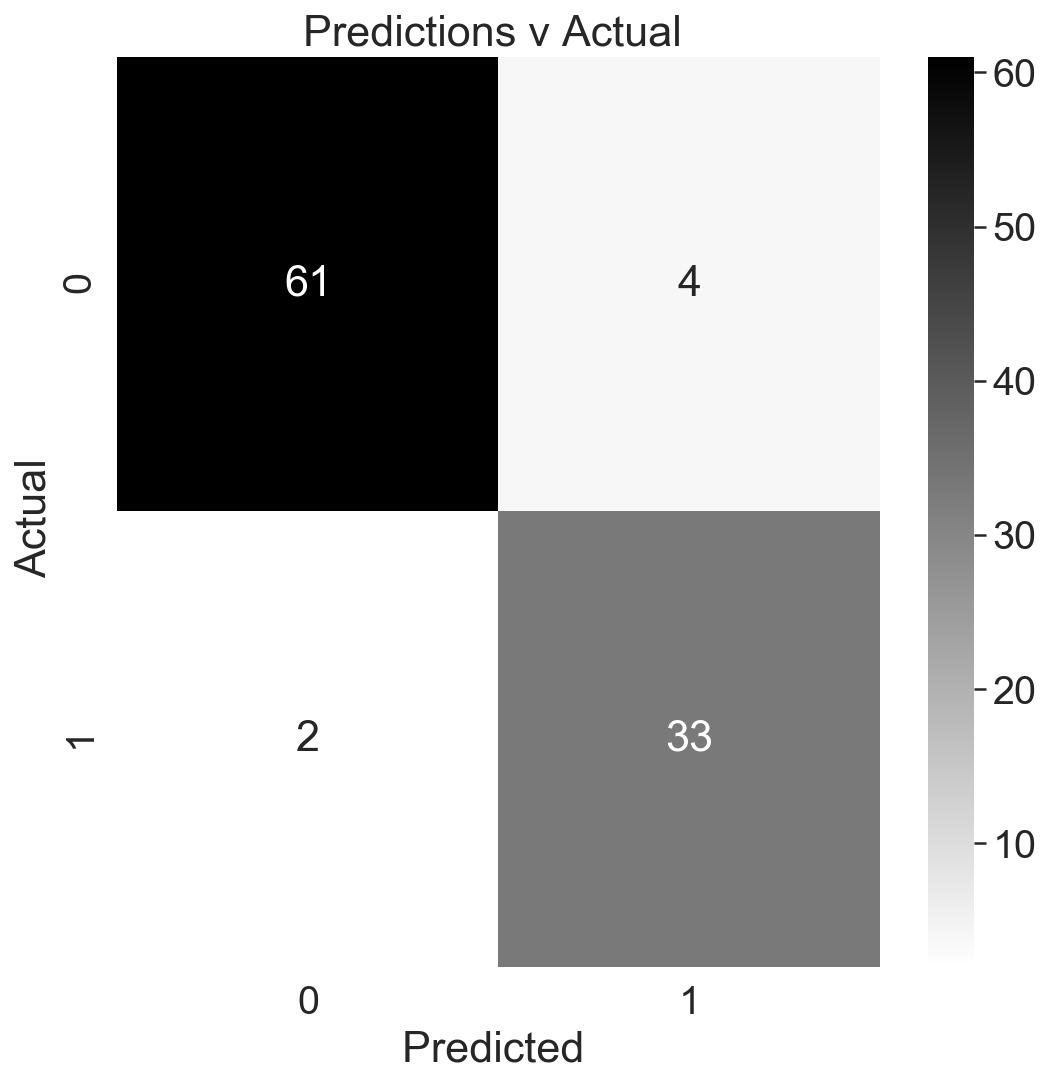

In [40]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_unseen7030, annot=True, fmt="d", cmap="gist_gray_r")
sns.set(font_scale=1.8)
plt.title("Predictions v Actual ")
plt.ylabel("Actual ")
plt.xlabel("Predicted ")
plt.tight_layout()

In [41]:
print("Accuracy Score:", accuracy_score(y_iranian7030, pred_unseen7030))
print("Precision Score :", precision_score(y_iranian7030, pred_unseen7030))
print("Recall Score:", recall_score(y_iranian7030, pred_unseen7030))
print("f1 Score:", f1_score(y_iranian7030, pred_unseen7030))

Accuracy Score: 0.94
Precision Score : 0.8918918918918919
Recall Score: 0.9428571428571428
f1 Score: 0.9166666666666667


### ANALYSIS:
The Iranian model turns in another strong strong performance despite the reduction in number of fake tweets, correctly classifying 94 tweets out of 100. It caught 33 of the 35 fake tweets, and only incorrectly classified 4 tweets as fake, when they are in fact real.

Let's see how the model performs in a 90-10 split, with even fewer fake tweets this time.

### 4.3 A 90-10 TEST
Now I'll shift the sampling weight such that the unseen test set has about 90% real tweets and 10% fake tweets.

In [42]:
iran_new_sample['90real_10fake'] = np.where(iran_new_sample['bot_or_not'] == 0, 0.9, 0.1)

In [43]:
iranian_test9010 = iran_new_sample.sample(n=100, random_state=42, weights='90real_10fake')

In [44]:
y_iranian9010 = iranian_test9010['bot_or_not']
X_iranian9010 = iranian_test9010['clean_tweet_text']

In [45]:
#Again, not precise but enough for the purpose of testing
y_iranian9010.value_counts()

0    86
1    14
Name: bot_or_not, dtype: int64

In [46]:
pred_unseen9010 = LR_iran.predict(X_iranian9010)
pred_unseen9010

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [47]:
cm_unseen9010 = confusion_matrix(y_iranian9010, pred_unseen9010)
cm_unseen9010

array([[85,  1],
       [ 0, 14]])

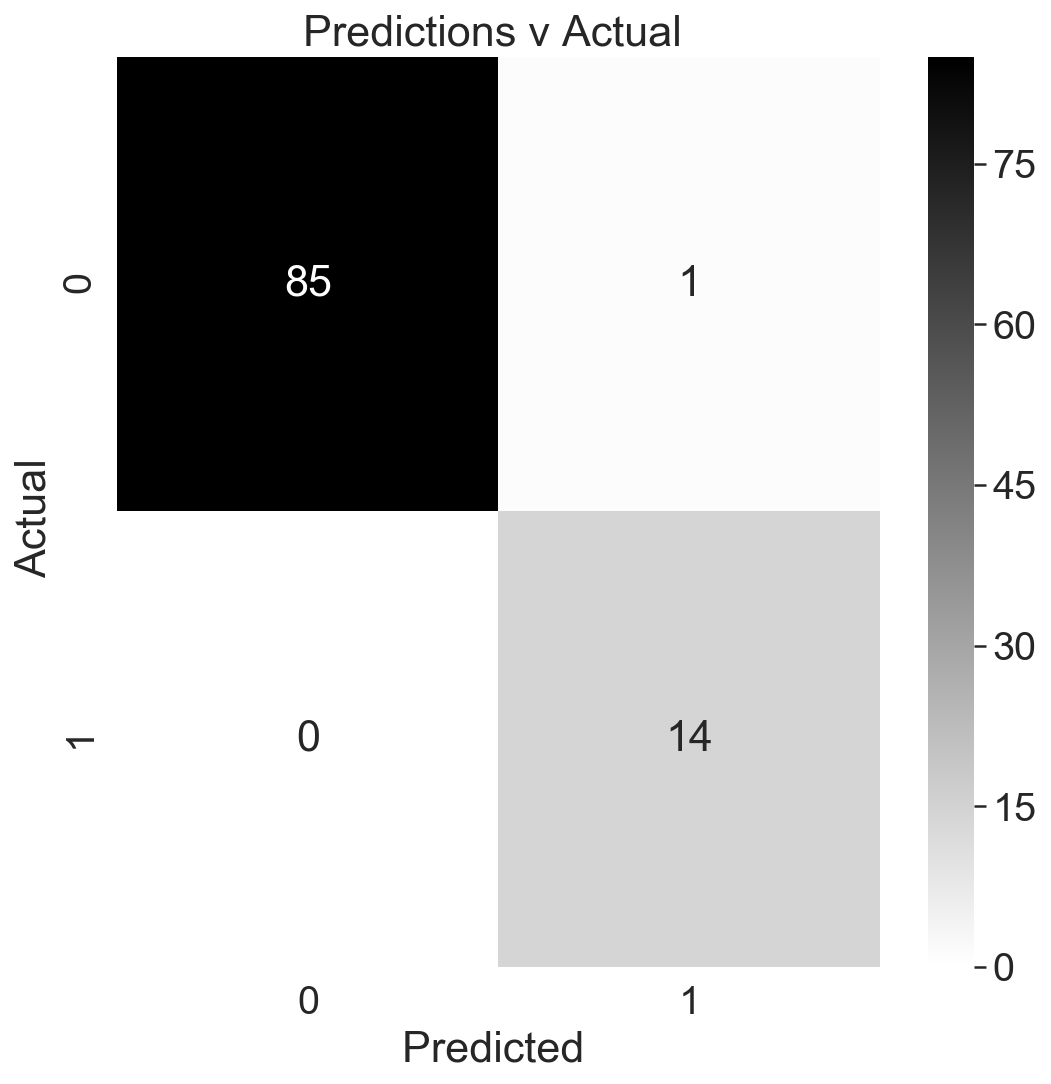

In [48]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_unseen9010, annot=True, fmt="d", cmap="gist_gray_r")
sns.set(font_scale=1.8)
plt.title("Predictions v Actual ")
plt.ylabel("Actual ")
plt.xlabel("Predicted ")
plt.tight_layout()

In [49]:
print("Accuracy Score:", accuracy_score(y_iranian9010, pred_unseen9010))
print("Precision Score :", precision_score(y_iranian9010, pred_unseen9010))
print("Recall Score:", recall_score(y_iranian9010, pred_unseen9010))
print("f1 Score:", f1_score(y_iranian9010, pred_unseen9010))

Accuracy Score: 0.99
Precision Score : 0.9333333333333333
Recall Score: 1.0
f1 Score: 0.9655172413793104


### ANALYSIS:
Surprisingly, the LogReg model continues to be able to pick out the fake tweets with ease, this time correctly classifying 14 out of all 14 fake tweets in the test set.

The model made just 1 mistake in this particular split - wrongly classifying 1 tweet as fake when it is in fact real.

The results from the 3 different sets of test show clearly that there's no "global" or generic solution when it comes to attempts to flush out these state operators on Twitter.

The most effective models are targetted and specific, trained on a set of tweets which have already betrayed the operator's particular style and focus. 

Put another way, a model trained on fake tweets from one state-operator isn't going to do well in catching the tweets by another state operator. This seems obvious, but can yet be a false assumption many could take in this topic.